In [1]:
import matplotlib.pyplot as plt
from data_helper import read_csv, read_exp_csv
from montecarlo2 import *
from scipy.optimize import minimize
import csv
%matplotlib widget

xs_min = 1.10 + 0.6 #cm, min distance + thumbscrew thickness
xd_min = 3.66 #cm

ah
10.44042306886455
7.62939888374183e-05


Running and Saving Data

In [7]:
exp_data = read_exp_csv('data.csv')
l = len(exp_data[0])

Data Fitting

In [86]:
def fit_data(data1, data2, S0):

    xd1 = data1[0] + xd_min
    xs1 = data1[1] + xs_min
    f1 = data1[2]
    u_f1 = data1[5]
    x1 = np.column_stack((xd1, xs1))

    xd2 = data2[0] + xd_min
    xs2 = data2[1] + xs_min
    f2 = data2[2]
    u_f2 = data2[5]
    x2 = np.column_stack((xd2, xs2))

    # Define RSS function
    def rss(S):
        return np.sum((f1 - S * f2) ** 2)
    
    

    
    # Minimize rss to find best scaling factor S
    options = {'xatol':u_S_calc}

    result = minimize(rss, x0=[S0], bounds=[(0, 10e10)], method='Nelder-Mead', options=options)
    S_best = result.x[0]

    u_s_over = [0 if f1[i] == 0 or S_best-f2[i]/f1[i] < 0 else (S_best-f2[i]/f1[i])/(f2[i]/f1[i]) for i in range(len(f1))]
    u_s_under = [0 if f1[i] == 0 or S_best-f2[i]/f1[i] > 0 else (S_best-f2[i]/f1[i])/(f2[i]/f1[i]) for i in range(len(f1))]

    n_s = np.sum(f1!=0)
    print(n_s)

    s = [0 if f1[i] == 0 else (f2[i]/f1[i]) for i in range(len(f1))]


    u_S_over = np.mean(u_s_over)/np.sqrt(n_s)
    u_S_under = np.mean(u_s_under)/np.sqrt(n_s)
    print(u_s_under)

    u_s = [0 if f1[i] == 0 else s[i]*np.sqrt( (u_f2[i]/f2[i])**2 +  (u_f1[i]/f1[i])**2 ) for i in range(len(f1))]

    u_S_stat = np.sum(u_s)/np.sqrt(n_s)




    mse = np.sum((f1-S_best*f2)**2)/101
    u_mse = mse * 2* np.sqrt( np.sum( ((u_f1)**2 + (S_best*u_f2)**2)/(f1+S_best*f2)**2 )  )


    print("S best " + str(S_best))
    print("uS over " + str(u_S_over))
    print("uS under " + str(u_S_under))
    print("uS stat " + str(u_S_stat))



    return rss(S_best), S_best  # Initial guess for S

Plotting

In [4]:

def reproduce_plots(data):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    d0_data = data[0:, 0:29]
    d5_data = data[0:, 29:44]
    d10_data = data[0:, 44:59]
    s0_data = data[0:,59:73]
    s5_data = data[0:,73:87]
    s10_data = data[0:, 87:]

    ax1.scatter(d0_data[0, :], d0_data[2, :],   lw = 1, color='red', alpha=0.5, label='d0')
    ax1.scatter(d5_data[0, :], d5_data[2, :],   lw = 1, color='green', alpha=0.5, label='d5')
    ax1.scatter(d10_data[0, :], d10_data[2, :],   lw = 1, color='blue', alpha=0.5, label='d10')

    ax2.scatter(s0_data[1, :], s0_data[2, :],  lw = 1, color='red', alpha=0.5, label='s0')
    ax2.scatter(s5_data[1, :], s5_data[2, :],   lw = 1, color='green', alpha=0.5, label='s5')
    ax2.scatter(s10_data[1, :], s10_data[2, :],  lw = 1, color='blue', alpha=0.5, label='s10')

    ax1.legend()
    ax2.legend()
    plt.show()


# Plot data again 
reproduce_plots(exp_data)

In [87]:
def plot_final(df, N, A):
    
    data2 = read_csv(df)
    data1 = exp_data

    fig = plt.figure(figsize=(8,6),dpi=200)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    rss, S = fit_data(data1, data2, 50)

    d0_data1 = data1[0:, 0:29]
    d5_data1 = data1[0:, 29:44]
    d10_data1 = data1[0:, 44:59]
    s0_data1 = data1[0:,59:73]
    s5_data1 = data1[0:,73:87]
    s10_data1 = data1[0:, 87:]

    ax1.errorbar(d0_data1[0, :] + xd_min, d0_data1[2, :], xerr=d0_data1[3,:], yerr=d0_data1[5,:], fmt='.',  lw = 1, color='red', alpha=0.5, label=r'$x_{s}$ = ' + str(0+np.round(xs_min,2)))
    ax1.errorbar(d5_data1[0, :]+ xd_min, d5_data1[2, :],  xerr=d5_data1[3,:], yerr=d5_data1[5,:],fmt='.', lw = 1, color='green', alpha=0.5, label=r'$x_{s}$ = ' + str(5+xs_min))
    ax1.errorbar(d10_data1[0, :]+ xd_min, d10_data1[2, :],  xerr=d10_data1[3,:], yerr=d10_data1[5,:], fmt='.',lw = 1, color='blue', alpha=0.5, label=r'$x_{s}$ = ' + str(10+xs_min))

    ax2.errorbar(s0_data1[1, :] + xs_min, s0_data1[2, :], xerr=s0_data1[4,:], yerr=s0_data1[5,:], fmt='.',lw = 1, color='red', alpha=0.5, label=r'$x_{d}$ = ' + str(0+xd_min))
    ax2.errorbar(s5_data1[1, :] + xs_min, s5_data1[2, :], xerr=s5_data1[4,:], yerr=s5_data1[5,:], fmt='.', lw = 1, color='green', alpha=0.5, label=r'$x_{d}$ = ' + str(5+xd_min))
    ax2.errorbar(s10_data1[1, :] + xs_min, s10_data1[2, :], xerr=s10_data1[4,:], yerr=s10_data1[5,:], fmt='.',lw = 1, color='blue', alpha=0.5, label=r'$x_{d}$ = ' + str(10+xd_min))

    
    data2[2,:] = data2[2,:] *S
    data2[5,:] = data2[5,:] *S

    d0_data2 = data2[0:, 0:29]
    d5_data2 = data2[0:, 29:44]
    d10_data2 = data2[0:, 44:59]
    s0_data2 = data2[0:,59:73]
    s5_data2 = data2[0:,73:87]
    s10_data2 = data2[0:, 87:]

    ax1.plot(d0_data2[0, :]+ xd_min, d0_data2[2, :],   lw = 1, color='red', alpha=0.5, label='Simulation')
    ax1.plot(d5_data2[0, :]+ xd_min, d5_data2[2, :],   lw = 1, color='green', alpha=0.5 )
    ax1.plot(d10_data2[0, :]+ xd_min, d10_data2[2, :],   lw = 1, color='blue', alpha=0.5)

    ax2.plot(s0_data2[1, :] + xs_min, s0_data2[2, :],  lw = 1, color='red', alpha=0.5, label='Simulation')
    ax2.plot(s5_data2[1, :] + xs_min, s5_data2[2, :],   lw = 1, color='green', alpha=0.5)
    ax2.plot(s10_data2[1, :] + xs_min, s10_data2[2, :],  lw = 1, color='blue', alpha=0.5)

    
    ax1.errorbar(d0_data2[0, :]+ xd_min, d0_data2[2, :], yerr=np.sqrt(d0_data2[2,:]*N)/N,  lw = 1, color='red', alpha=0.5)
    ax1.errorbar(d5_data2[0, :]+ xd_min, d5_data2[2, :],  yerr=np.sqrt(d5_data2[2,:]*N)/N, lw = 1, color='green', alpha=0.5 )
    ax1.errorbar(d10_data2[0, :]+ xd_min, d10_data2[2, :],  yerr=np.sqrt(d10_data2[2,:]*N)/N, lw = 1, color='blue', alpha=0.5)

    ax2.errorbar(s0_data2[1, :] + xs_min, s0_data2[2, :], yerr=np.sqrt(s0_data2[2,:]*N)/N, lw = 1, color='red', alpha=0.5)
    ax2.errorbar(s5_data2[1, :] + xs_min, s5_data2[2, :],  yerr=np.sqrt(s5_data2[2,:]*N)/N, lw = 1, color='green', alpha=0.5)
    ax2.errorbar(s10_data2[1, :] + xs_min, s10_data2[2, :], yerr=np.sqrt(s10_data2[2,:]*N)/N,  lw = 1, color='blue', alpha=0.5)

    ax1.legend()
    ax2.legend()

    ax1.set_xlabel(r'$x_{d}$')
    ax2.set_xlabel(r'$x_{s}$')
    ax1.set_ylabel('Rate (1/s)')

    u_A_sys = 4.997e-4

    z = A * (mass_Au/density) * (4*E_alpha/(k*q*Q))**2
    u_z_fit = z * u_A_calc/A
    u_z_stat = z*(u_E_squared/E_squared)
    u_z_sys = z*(u_A_sys/A)



    act = (S)/uCi

    u_act = u_S_calc/uCi

    fig.suptitle('Detection Rate vs Target Position - Simulation vs Experiment')

    
    print("S " + str(S))
    print("uS " + str(u_S_calc))
    print(str())
    print("act " + str(act))
    print("u_act " + str(u_act))
    print("z " + str(z))
    print("u_z_fit " + str(u_z_fit))
    print("u_z_stat " + str(u_z_stat))


    ax1.text(11.9, 24.5, 'MSE = ' + str(np.round(rss/101,2)) + '\nN = ' + str(N), bbox=dict(facecolor='red', alpha=0.5))


    plt.show()
    



plot_final("rutherford_mc_fast_opt_lowconf 500000000.0004196699441870914.csv", 50000000, 4.197e-04)

101
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
S best 1322037.5
uS over 284182714918.5521
uS under 0.0
uS stat 3.053173776295202e-07
S 1322037.5
uS 10.44042306886455

act 35.730743243243246
u_act 0.0002821735964557987
z 0.005501083200596255
u_z_fit 0.00022432690431600045
u_z_stat 0.001100216640119251


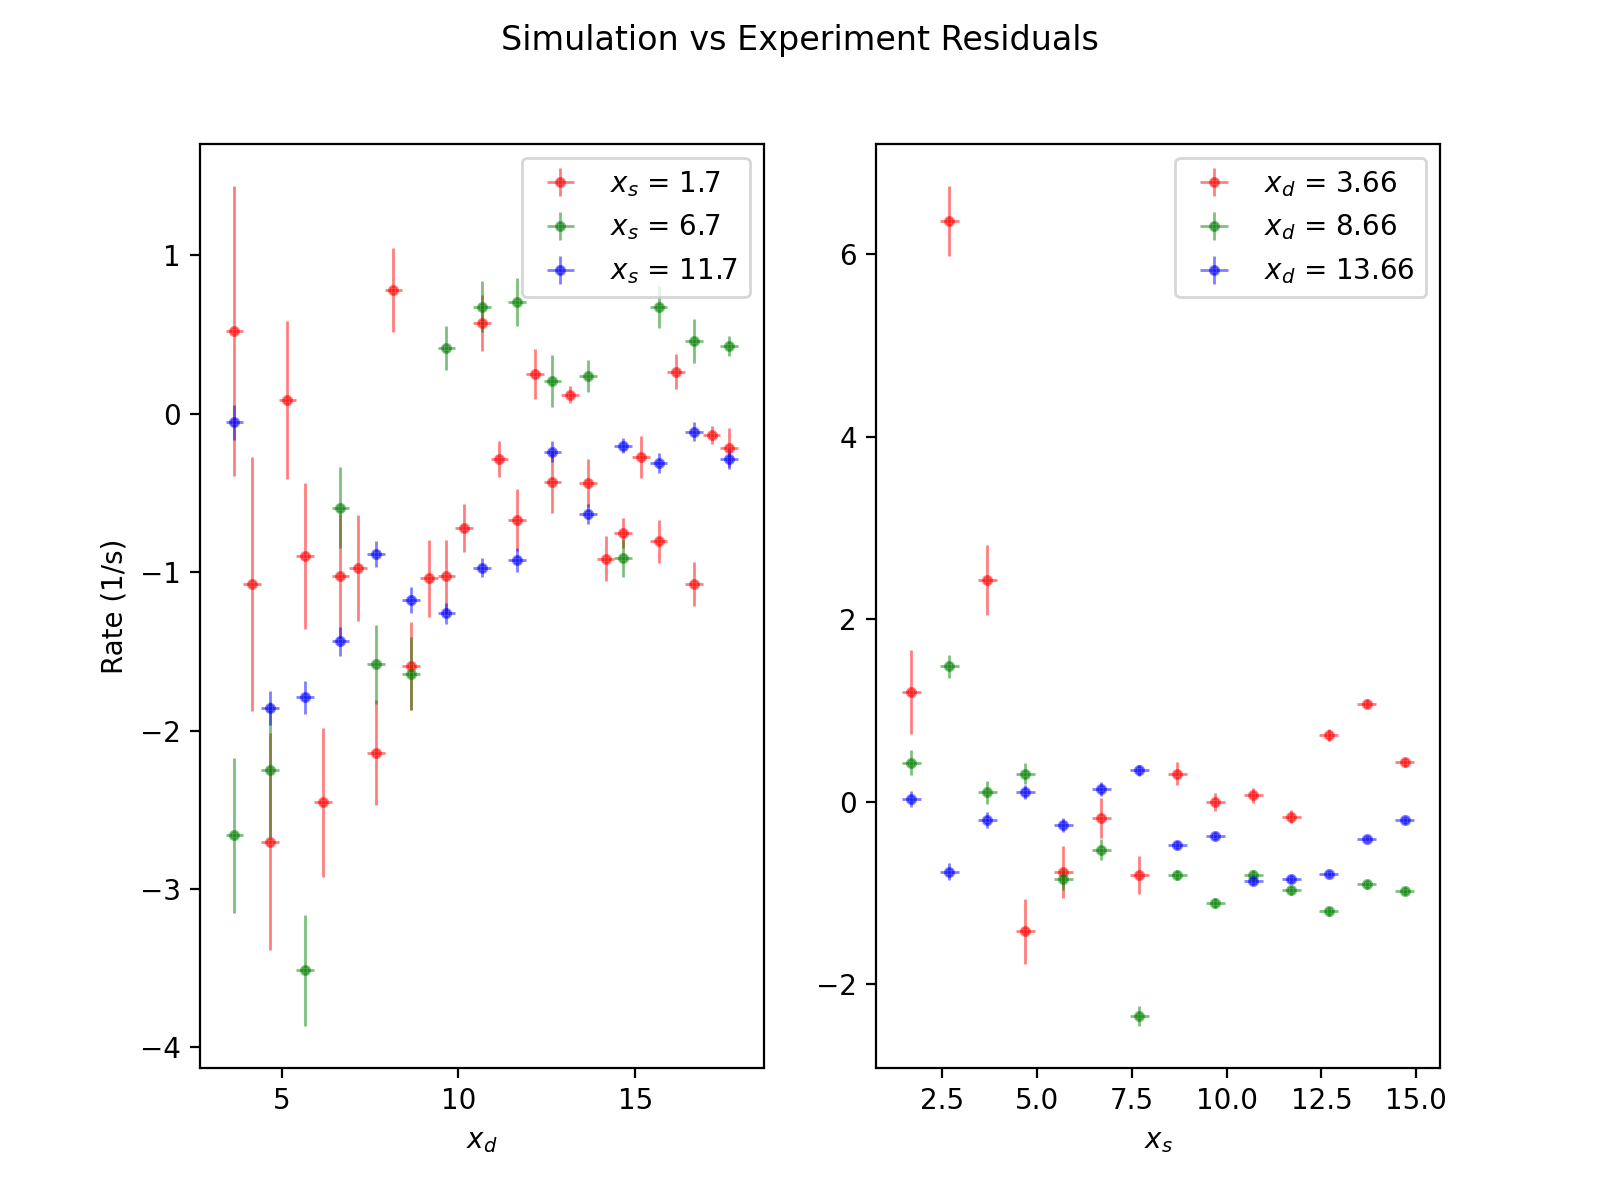

In [46]:
def plot_residuals(name, N):
    data2 = read_csv(name)
    data1 = exp_data

    fig = plt.figure(figsize=(8,6),dpi=200)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    
    rss, S = fit_data(data1, data2, 50)

    d0_data1 = data1[0:, 0:29]
    d5_data1 = data1[0:, 29:44]
    d10_data1 = data1[0:, 44:59]
    s0_data1 = data1[0:,59:73]
    s5_data1 = data1[0:,73:87]
    s10_data1 = data1[0:, 87:]

    
    
    data2[2,:] = data2[2,:] *S
    data2[5,:] = data2[5,:] *S

    d0_data2 = data2[0:, 0:29]
    d5_data2 = data2[0:, 29:44]
    d10_data2 = data2[0:, 44:59]
    s0_data2 = data2[0:,59:73]
    s5_data2 = data2[0:,73:87]
    s10_data2 = data2[0:, 87:]

    
    ax1.errorbar(d0_data1[0, :] + xd_min, d0_data2[2, :]-d0_data1[2, :], xerr=d0_data1[3,:], yerr=d0_data1[5,:]+np.sqrt(d0_data2[2,:]*N)/N, fmt='.',  lw = 1, color='red', alpha=0.5, label=r'$x_{s}$ = ' + str(0+np.round(xs_min,2)))
    ax1.errorbar(d5_data1[0, :]+ xd_min, d5_data2[2, :]-d5_data1[2, :],  xerr=d5_data1[3,:], yerr=d5_data1[5,:]+np.sqrt(d5_data2[2,:]*N)/N,fmt='.', lw = 1, color='green', alpha=0.5, label=r'$x_{s}$ = ' + str(5+xs_min))
    ax1.errorbar(d10_data1[0, :]+ xd_min, d10_data2[2, :]-d10_data1[2, :],  xerr=d10_data1[3,:], yerr=d10_data1[5,:]+np.sqrt(d10_data2[2,:]*N)/N, fmt='.',lw = 1, color='blue', alpha=0.5, label=r'$x_{s}$ = ' + str(10+xs_min))

    ax2.errorbar(s0_data1[1, :] + xs_min, s0_data2[2, :]-s0_data1[2, :], xerr=s0_data1[4,:], yerr=s0_data1[5,:]+np.sqrt(s0_data2[2,:]*N)/N, fmt='.',lw = 1, color='red', alpha=0.5, label=r'$x_{d}$ = ' + str(0+xd_min))
    ax2.errorbar(s5_data1[1, :] + xs_min, s5_data2[2, :]-s5_data1[2, :], xerr=s5_data1[4,:], yerr=s5_data1[5,:]+np.sqrt(s5_data2[2,:]*N)/N, fmt='.', lw = 1, color='green', alpha=0.5, label=r'$x_{d}$ = ' + str(5+xd_min))
    ax2.errorbar(s10_data1[1, :] + xs_min, s10_data2[2, :]-s10_data1[2, :], xerr=s10_data1[4,:], yerr=s10_data1[5,:]+np.sqrt(s10_data2[2,:]*N)/N, fmt='.',lw = 1, color='blue', alpha=0.5, label=r'$x_{d}$ = ' + str(10+xd_min))


    ax1.legend()
    ax2.legend()

    ax1.set_xlabel(r'$x_{d}$')
    ax2.set_xlabel(r'$x_{s}$')
    ax1.set_ylabel('Rate (1/s)')

    fig.suptitle('Simulation vs Experiment Residuals')
    plt.show()

plot_residuals("rutherford_mc_fast_opt_lowconf 500000000.0004196699441870914.csv", 50000000)

    


In [ ]:
plot_final(["final_fastmc_opt.csv"], [50000000])

In [ ]:
plot_final(["final_fastmc_cos_opt.csv"], [50000000])

In [ ]:
plot_final(["rutherford_ang_mc_fast 500000001.5707963267948966.csv"], [50000000])

In [ ]:
plot_final(["rutherford_ang_cos_mc_fast 500000000.7853981633974483.csv"], [50000000])

In [ ]:
plot_final(["rutherford_ang_cos_mc_fast 500000001.5707963267948966.csv"], [50000000])

In [ ]:
plot_final(["rutherford_ang_cos_mc_fast 500000003.141592653589793.csv"], [50000000])

In [ ]:
plot_final(["rutherford_mc_fast_opt 5000003.8199999792558914e-05.csv"], [500000])

Optimize Monte Carlo

In [ ]:
def rutherford_opt(N, A):
    data = np.array([exp_data[0], exp_data[1], np.zeros(l), np.zeros(l), np.zeros(l), np.zeros(l)])
    xx = np.transpose(data[0:2])
    results = np.transpose(np.array([simop_rutherford_fast(x[0],x[1],N,A) for x in xx]))
    data[2] = (results[0].astype(float))/float(N)
    data[5] = (results[1].astype(float))/float(N)
    return data


def rutherford_cos_opt(N, A):
    data = np.array([exp_data[0], exp_data[1], np.zeros(l), np.zeros(l), np.zeros(l), np.zeros(l)])
    xx = np.transpose(data[0:2])
    results = np.transpose(np.array([simop_rutherford_cos_fast(x[0],x[1],N,A) for x in xx]))
    data[2] = (results[0].astype(float))/float(N)
    data[5] = (results[1].astype(float))/float(N)
    return data

def optimize_mc(N,A0):
    S_list = []
    S_var_list = []
    chi_list =[]

    def fit_data(data1, data2, S):
        xd1 = data1[0] + xd_min
        xs1 = data1[1] + xs_min
        f1 = data1[2]
        u_f1 = data1[5]
        x1 = np.column_stack((xd1, xs1))

        xd2 = data2[0] + xd_min
        xs2 = data2[1] + xs_min
        f2 = data2[2]
        u_f2 = data2[5]
        x2 = np.column_stack((xd2, xs2))

        # Define chi-square function
        def chi_square(S):
            chi2 = np.sum(((f1 - S * f2) ** 2) / (u_f1**2 + (S*u_f2) ** 2))
            return chi2
        
       
        # Minimize chi-square to find best scaling factor S
        return chi_square(S)  # Initial guess for S
        
        
    def model_chi(param):
        A,S = param[1], param[0]
        print("Simulating A = " + str(A) + ", S = " + str(S) + ", for N = " + str(N) + "...")
        chi = fit_data(exp_data, rutherford_opt(N,A), S)
        S_list.append(S)
        chi_list.append(chi)
        print("Chi-squared = " + str(chi))
        return chi
    
    result = minimize(model_chi, [1260000, A0], bounds=((0,200)))
    A_best,S_best = result.x[0]

    data_best = rutherford_cos_opt(N*5,A_best)
    csv_name = 'rutherford_mc_fast_opt ' + str(N*5) +str(A_best)+ '.csv'
    np.savetxt(csv_name, data_best.transpose(), delimiter=',',fmt='%.10e')
    print("Saved " + 'rutherford_mc_fast_opt ' + str(N*5) +str(A_best)+ '.csv')

    print(A_best)
    print(S_best)
    print(chi_list[-1])

    plot_final([csv_name],[N*5])


In [ ]:
optimize_mc(1000000,3.82e-5)